# Identifying type of opinions in spanish wikipedia discussions 

In this analysis, we are going to automatically identify the kind of opinion of authors in the discussions on talk pages of spanish wikipedia.

In [177]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#matplotlib.style.use('seaborn-ticks')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18
sns.set_style('ticks')

Load our labelled dataset, containing the opinions in the talk pages of wikipedia segmented by sentences assuming normal punctuation. This dataset includes the initial 1000 edits of talk pages of political leaders in America.

In [188]:
ds = pd.read_csv('data/wdds.csv')
ds.shape
ds.columns

Index(['row_id', 'page_id', 'page_title', 'contributor', 'timestamp',
       'creation_dt', 'topic', 'opinion', 'clean_opinion', 'turn',
       'segmentation', 'type', 'subtype', 'type_r1', 'subtype_r1', 'type_r2',
       'subtype_r2', 'stance', 'sentiment', 'url'],
      dtype='object')

remove unnecesary label 'discusión' in title

In [97]:
ds['page_title'] = ds.page_title.str.replace('Discusión:', '')

In [191]:
ds['created_date'] = pd.to_datetime(ds.creation_dt)

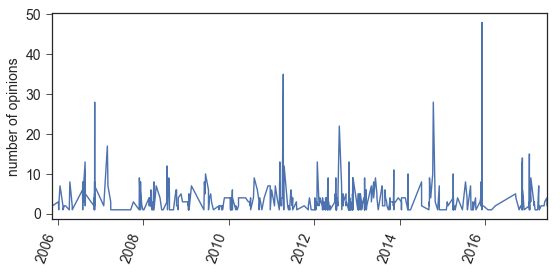

In [216]:
plt.figure(figsize=(8,4))
ts = ds.groupby(['created_date']).size()
ts.plot()
plt.xticks(rotation=70)
plt.xlabel('')
plt.ylabel('number of opinions')
#plt.title('Temporal contribution by authors')
plt.tight_layout()
plt.savefig('output/temporalauthorcontribdist.eps', format='eps',bbox_inches='tight')

it seems there's some spikes at certain dates, probably related to real world events.  Now, let make the text analysis of the opinions.

# text analysis

First, lets look characterize the opinions. First, let's analyze the length of the opinions and number of words

In [159]:
ds=ds[~ds.type.isnull()]
ds[['row_id','type']].groupby('type').count()
# copy the manually revised clean_opinion 
ds['opinion'] = ds['clean_opinion']

as in most human activities, the length of opinions follow an power law distribution.  Now, let's look at the number of words:

In [160]:
from nltk.tokenize import word_tokenize

In [161]:
ds.opinion.fillna(value='', inplace=True)

In [162]:
ds['opnumwords'] = ds.opinion.apply(lambda s: len(word_tokenize(s, 'spanish')))

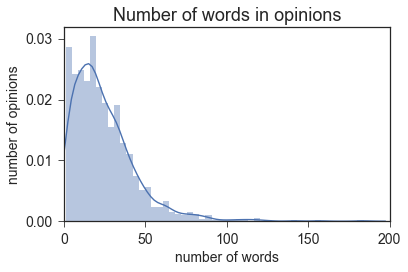

In [179]:
#ds.opnumwords.hist(bins=100)

sns.distplot(ds.opnumwords)
plt.xlabel('number of words')
plt.ylabel('number of opinions')
plt.title('Number of words in opinions')
plt.xlim([0, 200])
plt.tight_layout()
plt.savefig('output/numwordsopdist.eps', format='eps')

as expected the distribution of length of words is very similar to characters in opinions. Although there are opinions with only one word, it may be useful to know what kind of opinions are those:

In [114]:
ds[ds.opnumwords<2].opinion.value_counts().head()

saludos         9
saludos         5
gracias         3
criminalidad    1
gracias.-       1
Name: opinion, dtype: int64

some of them are meaningless others make sense such as: saludos, paz, gracias.  One of the challeges in the classification task will be to filter out meaningless words but filtering out useful words, specially when both have the similar frequencies.  Let's look at most used words with a word cloud excluding stop words.

In [205]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import datetime
use_stemmer = False
stemmer = SnowballStemmer("spanish")
stopset = set(stopwords.words('english') + stopwords.words('spanish'))

def tokenize(text):
    text = re.sub(r"(?:\#|@|https?\://)\S+", "", text)
    text = re.sub("[^a-zA-Z] ","",text)
    text = re.sub(r'\b\w{1,2}\b',' ',text)
    text = re.sub(r'http[\bs]*',' ',text)
    tokens = word_tokenize(text)
    if use_stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return tokens

words = ' '.join(ds[(ds.created_date>datetime.date(2015,1,1))
                   &(ds.created_date<datetime.date(2017,1,1))].opinion)

word_list = word_tokenize(words)
word_list = [word for word in word_list if word not in stopset]
print(f'number of words with simple tokenization: {len(word_list)}')

use_stemmer=True
word_list = tokenize(words)
word_list = [word for word in word_list if word not in stopset]
print(f'number of words with stemming removal: {len(word_list)}')

use_stemmer=False
word_list = tokenize(words)
word_list = [word for word in word_list if word not in stopset]
print(f'number of words with stop words removal: {len(word_list)}')


wds = pd.DataFrame(word_list)
wds.columns = ['word']
wds=wds.word.value_counts().reset_index()
wds.columns=['word', 'count']
wds=wds[(wds['count']>2) & (wds['count']<10)]
print(f'number of words (TF min:3): {len(wds)}')


number of words with simple tokenization: 4878
number of words with stemming removal: 3623
number of words with stop words removal: 3414
number of words (TF min:3): 176


In [206]:
wds.sort_values('count', ascending=False).head()

,word,count
23,elegido,9
25,procesado,9
26,dice,9
27,elección,9
24,puede,9


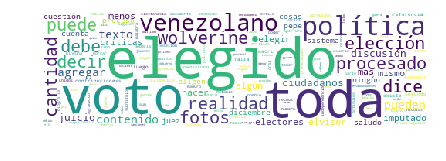

In [220]:
from wordcloud import WordCloud
filtered_words = ' '.join(wds.word)
wordcloud = WordCloud(background_color='white', width=500, height=150).generate(filtered_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0,h_pad=0, w_pad=0)
plt.savefig('output/wordcloud.png',bbox_inches='tight')

# classification task

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit

In [157]:
ds['target'] = ds['type']

In [154]:

# X_train, X_test, y_train, y_test = train_test_split(
#     ds.opinion, ds.target, test_size=0.4, random_state=0)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
sss.get_n_splits(ds.opinion, ds.target)

print(sss)       

for train_index, test_index in sss.split(ds.opinion, ds.target):
   #print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = ds.iloc[train_index].opinion, ds.iloc[test_index].opinion
   y_train, y_test = ds.iloc[train_index].target, ds.iloc[test_index].target

print(f'train size: {X_train.shape[0]}')
print(f'test size: {X_test.shape[0]}')

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.4,
            train_size=None)
train size: 935
test size: 624


In [155]:
text_vectorizer = [
    ('vect', CountVectorizer(strip_accents='ascii', 
                             min_df=3, max_df=0.9,
                             stop_words=stopset, 
                             tokenizer=tokenize)),
    ('tfidf', TfidfTransformer(use_idf=True, sublinear_tf=True))
]

multinb_clf = Pipeline(text_vectorizer+[('clf', MultinomialNB())])
lsvc_clf = Pipeline(text_vectorizer+[('clf', LinearSVC())])
mf_clf = Pipeline(text_vectorizer+[('clf', DummyClassifier(strategy='most_frequent', random_state=0))])
uniform_clf = Pipeline(text_vectorizer+[('clf', DummyClassifier(strategy='uniform', random_state=0))])
strat_clf = Pipeline(text_vectorizer+[('clf', DummyClassifier(strategy='stratified', random_state=0))])
use_stemmer = True

## Evaluation of the performance on the test set

In [156]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

summary_scores = ['CI (95\%)', '']

uniform_clf.fit(X_train, y_train)
scores = cross_val_score(uniform_clf, X_train, y_train)
confidence_interval = scores.std() * 2
print("RND Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), confidence_interval))
summary_scores.extend([confidence_interval, '', ''])

parameters = {'clf__C':[0.1, 1, 10]}
parameters['clf__loss']=('hinge','squared_hinge')
parameters['clf__multi_class']= ('ovr', 'crammer_singer')
parameters['clf__class_weight'] = (None, 'balanced')
parameters['clf__tol'] = [1e-3, 1e-4]
lsvc_cv = GridSearchCV(lsvc_clf, parameters)
lsvc_cv.fit(X_train, y_train)
scores = cross_val_score(lsvc_cv, X_train, y_train)
confidence_interval = scores.std() * 2
print(f"LSVC best score: {lsvc_cv.best_score_}")
print(f"LSVC best params: {lsvc_cv.best_params_}")
print("LSVC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), confidence_interval))
summary_scores.extend([confidence_interval, '',''])

parameters = {'clf__alpha':[ 0.1, 1.0, 10.0]}
parameters['clf__fit_prior']= [True, False]
multinb_cv = GridSearchCV(multinb_clf, parameters)
multinb_cv.fit(X_train, y_train)
scores =  cross_val_score(multinb_cv, X_train, y_train)
confidence_interval = scores.std() * 2
print(f"MNB best score: {multinb_cv.best_score_}")
print(f"MNB best params: {multinb_cv.best_params_}")
print("MNB Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), confidence_interval))
summary_scores.extend([confidence_interval, '',''])



RND Accuracy: 0.34 (+/- 0.03)
LSVC best score: 0.6459893048128342
LSVC best params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__loss': 'squared_hinge', 'clf__multi_class': 'ovr', 'clf__tol': 0.001}
LSVC Accuracy: 0.65 (+/- 0.05)
MNB best score: 0.5989304812834224
MNB best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
MNB Accuracy: 0.59 (+/- 0.04)


In [158]:
from sklearn.metrics import precision_recall_fscore_support

docs_test = X_test
labels = y_test.unique()
labels.sort()
rds = pd.DataFrame({'Label': labels})
macro_results = ['Macro', len(y_test)]

predicted = uniform_clf.predict(docs_test)
results = precision_recall_fscore_support(y_test, predicted)
macro_results.extend(precision_recall_fscore_support(y_test, predicted, average='macro')[:3])
rds['Support'] = results[3]
rds['BL-P'] = results[0]
rds['BL-R'] = results[1]
rds['BL-F1'] = results[2]

predicted = lsvc_cv.predict(docs_test)
results = precision_recall_fscore_support(y_test, predicted)
macro_results.extend(precision_recall_fscore_support(y_test, predicted, average='macro')[:3])
rds['LSVC-P'] = results[0]
rds['LSVC-R'] = results[1]
rds['LSVC-F1'] = results[2]

predicted = multinb_cv.predict(docs_test) 
results = precision_recall_fscore_support(y_test, predicted)
macro_results.extend(precision_recall_fscore_support(y_test, predicted, average='macro')[:3])
rds['MNB-P'] = results[0]
rds['MNB-R'] = results[1]
rds['MNB-F1'] = results[2]

rds.loc[len(rds)]=macro_results
rds.loc[len(rds)]=summary_scores

rds.to_csv('output/classif_report.csv', index=False)
rds

,Label,Support,BL-P,BL-R,BL-F1,LSVC-P,LSVC-R,LSVC-F1,MNB-P,MNB-R,MNB-F1
0,ARGUMENTATIVE,311,0.449074,0.311897,0.368121,0.670520,0.745981,0.70624,0.593668,0.723473,0.652174
1,INTERPERSONAL,58,0.103286,0.37931,0.162362,0.844828,0.844828,0.844828,0.936170,0.758621,0.838095
2,PERFORMATIVE,255,0.389744,0.298039,0.337778,0.627273,0.541176,0.581053,0.535354,0.415686,0.467991
3,Macro,624,0.314035,0.329749,0.28942,0.714207,0.710662,0.710707,0.688397,0.632593,0.652753
4,CI (95\%),,0.027643,,,0.053794,,,0.038600,,


In [69]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[253,   0,  53],
       [ 13,  37,   4],
       [168,   0,  96]])

# model usage

In [70]:
sample = X_test[:2]
labels = y_test[:2]

docs_new = sample
predicted = lsvc_cv.predict(docs_new)

for doc, label, pred in zip(docs_new, labels, predicted):
    print('%r => %s, %s' % (doc, label, pred))


'"el 5 de marzo de 2013, a las 5:20pm, el vicepresidente de la república nicolás maduro, anuncia en cadena nacinal el fallecimiento del presidente hugo chávez, quien falleció a las 4:25pm del mismo día"' => PERFORMATIVE, PERFORMATIVE
'* http://lanacion.cl/prontus_noticias_v2/site/artic/20090322/pags/20090322234158.html' => PERFORMATIVE, PERFORMATIVE
